# Setup

In [1]:
## !git clone https://github.com/sqrx-mckl/driver_behaviour.git
# %cd driver_behaviour
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import sys
from tensorflow.python.keras import __package__ as keras_package
print (sys.modules[keras_package].__version__)

2.2.4-tf


# Clustering
I have the data sequenced from the previous event cutting algorithm
I have some statistical analysis applied on the 

Now I will:
* Apply GAN Bi-GRU on those sequences
* get a categorisation by the GAN
* plot in a new T-SNE / UMAP each sequences projected from the new encoding

## Source
This is heavily inspired (with copy/paste) from the following article:
[Data Exploration with Adversarial Autoencoders](https://towardsdatascience.com/data-exploration-with-adversarial-autoencoders-311a4e1f271b)


In [3]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np

from pprint import pprint
from IPython.display import display
from typing import Dict, Union, List, Callable, Tuple
from pathlib import Path

import lib.analysis

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

sns.set_style('darkgrid')
sns.set_context('notebook')

pd.set_option('max_columns', None)

In [4]:
folderpath = Path('data/UAH-DRIVESET-v1/')
# folderpath = Path('/content/drive/My Drive/Data/driver_behaviour/')

# Model/data preparation and training

## Prepare the data

Here I would like to focus on Tensorflow first and foremost, the Dask usage can be managed later.

Hence I will only retrieve the data I need.

In [5]:
df = pd.read_parquet(Path(folderpath, 'data_ready.parquet'))
df = df.sort_values(['corner_select', 'timestamp'])

In [6]:
split_by = 'corner_select'
col = [
    'gx',
    'gy',
    'yr',
    'speed',
    'distx',
    'disty',
    'time_event',
]
feat = [
    'gx',
    'gy',
    'yr',
    'speed',
]

## Split Train/Test

Those plots are good to check the good repartition between train and test data.
- "lib.analysis.plot_gx_gy()"
- "lib.analysis.plot_gy_speed()"

There is no really test data, as the test data is fake data created to confuse the determinators

In [7]:
from sklearn.model_selection import train_test_split

# train_ix, test_ix = train_test_split(df[split_by].unique(), test_size=0.30)
train_ix = df[split_by].unique()
test_ix = df[split_by].unique()

df_train = df[[*feat,split_by]].where(lambda x: x[split_by].isin(train_ix)).dropna()
df_test = df[[*feat,split_by]].where(lambda x: x[split_by].isin(test_ix)).dropna()

df = df[[*col,split_by]]

In [8]:
display(f'{df_train[split_by].unique().shape[0]} / {df_test[split_by].unique().shape[0]} / {df[split_by].unique().shape[0]} (train/test/total) event')

'159 / 159 / 159 (train/test/total) event'

## Make the Batch sequences

In [9]:
train_mean = df_train.mean()
train_std = df_train.std()
train_max = df_train.max()

def normalize_data(df, mean=train_mean, std=train_std, split_by=split_by) -> pd.DataFrame:
    df_num = df.drop(columns=split_by).select_dtypes('number')
    df_obj = df.drop(columns=split_by).select_dtypes(exclude='number')

    df_num = (df_num - mean) / std

    # Some specific case - mainly time:
    if df_num.columns.isin(['time_event']).any():
        df_num['time_event'] = df['time_event'] / df['time_event'].max()

    if df_obj.empty:
        df_norm = df_num
    else:
        df_norm = df_num.join(pd.get_dummies(df_obj))

    return df_norm.join(df[split_by])

In [10]:
df_train = normalize_data(df_train)
df_test = normalize_data(df_test)
data = normalize_data(df)

display(df_train.head())

,gx,gy,yr,speed,corner_select
173,-0.921039,-0.721824,-0.034389,0.095295,12km-D5-AGGRESSIVE-SECONDARY28x41
174,-0.037771,-0.705607,-0.032554,0.099218,12km-D5-AGGRESSIVE-SECONDARY28x41
175,0.710909,-0.475320,-0.027680,0.103140,12km-D5-AGGRESSIVE-SECONDARY28x41
176,0.249779,-0.329626,-0.023465,0.107063,12km-D5-AGGRESSIVE-SECONDARY28x41
177,-0.244675,-0.312195,-0.022313,0.110985,12km-D5-AGGRESSIVE-SECONDARY28x41


## Pad sequences
Unfortunetely all our sequences are not of the same size as seen in graph below

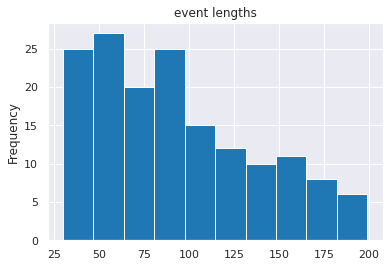

In [11]:
plt.figure()
df_train.groupby(split_by)[split_by].count().plot(kind='hist')
plt.title('event lengths');

In [12]:
from tensorflow.python.keras.preprocessing import sequence

def sequence_data(df, split_by=split_by) -> Tuple[pd.Index, np.array]:
    dataset = df.copy()
    
    dataset = dataset.groupby(split_by).progress_apply(
        lambda x: x.drop(columns=[split_by]).values
    )
    
    dataset_idx = dataset.index
    x = sequence.pad_sequences(dataset.values, padding='post', value=0, dtype='float64')
    
    return dataset, x

train_dataset, train_x = sequence_data(df_train)
test_dataset, test_x = sequence_data(df_test)
dataset, data_x = sequence_data(data)

display(train_dataset.shape)
display(train_x.shape)
display(train_x.shape)

corner_select
12km-D5-AGGRESSIVE-SECONDARY28x41    [[-0.921039001226908, -0.7218240778604993, -0....
12km-D5-AGGRESSIVE-SECONDARY56x01    [[-0.05763560447574208, 0.4498032531748537, 0....
12km-D5-AGGRESSIVE-SECONDARY6x91     [[0.9138860443757698, 0.43060252740267, 0.0036...
13km-D1-DROWSY-SECONDARY2x14         [[0.05940032008395211, 0.42707579808932333, 0....
13km-D1-DROWSY-SECONDARY61x24        [[0.26726184666199093, -0.8562428469764055, 0....
                                                           ...                        
26km-D6-NORMAL-MOTORWAY4x47          [[-0.6564177714703819, -0.7662556922486031, 0....
26km-D6-NORMAL-MOTORWAY70x07         [[-0.5285233216679195, 0.7821540019586432, 0.0...
26km-D6-NORMAL-MOTORWAY88x87         [[-0.23920133567578739, 0.3849390985134258, -0...
26km-D6-NORMAL-MOTORWAY91x07         [[-0.18792525494380788, 0.3412703166610081, 0....
26km-D6-NORMAL-MOTORWAY98x97         [[1.8183027019480877, -0.8495226591849383, 0.2...
Length: 159, dtype: object

(159, 199, 4)

array([[[-9.21039001e-01, -7.21824078e-01, -3.43892592e-02,
          9.52953149e-02],
        [-3.77707495e-02, -7.05606976e-01, -3.25544773e-02,
          9.92178168e-02],
        [ 7.10908791e-01, -4.75319584e-01, -2.76795783e-02,
          1.03140299e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[-5.76356045e-02,  4.49803253e-01,  4.02944219e-03,
          9.30666226e-01],
        [ 3.43214437e-01,  2.94184714e-01,  4.53391858e-03,
          9.35146525e-01],
        [ 6.42946328e-01,  1.57563603e-01,  8.40548093e-03,
          9.39626801e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.000

## Setup the Model

In [ ]:
latent_dim = 32
cat_dim = 4

In [13]:
from tensorflow.python.keras.models import Sequential, Input, Model
from tensorflow.python.keras.layers import (
    Bidirectional, Dropout, TimeDistributed,
    BatchNormalization, PReLU, ELU,
    Concatenate, RepeatVector, Subtract,
    LSTM, Dense
)
# from tensorflow_core.python.keras.optimizers import adam

In [14]:
window_size = train_x.shape[1]
input_dim = train_x.shape[2]

prior_discriminator = lib.analysis.demo_create_discriminator(latent_dim)
prior_discriminator.compile(loss='binary_crossentropy', 
                            optimizer='adam',
                            metrics=['accuracy'])

prior_discriminator.trainable = False

cat_discriminator = lib.analysis.demo_create_discriminator(cat_dim)
cat_discriminator.compile(loss='binary_crossentropy', 
                          optimizer='adam', 
                          metrics=['accuracy'])

cat_discriminator.trainable = False

encoder = lib.analysis.demo_create_encoder(latent_dim, cat_dim, window_size, input_dim)

signal_in = Input(shape=(window_size, input_dim))
reconstructed_signal, encoded_repr, category, _ = encoder(signal_in)

is_real_prior = prior_discriminator(encoded_repr)
is_real_cat = cat_discriminator(category)

autoencoder = Model(signal_in, [reconstructed_signal, is_real_prior, is_real_cat])
autoencoder.compile(
    loss=['mse', 'binary_crossentropy', 'binary_crossentropy'],
    loss_weights=[0.99, 0.005, 0.005],
    optimizer='adam'
)

In [16]:
display(prior_discriminator.summary())
display(cat_discriminator.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
elu (ELU)                    (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
elu_1 (ELU)                  (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 18,946
Trainable params: 9,473
Non-trainable params: 9,473
______________________________________________________

None

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               640       
_________________________________________________________________
elu_2 (ELU)                  (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
elu_3 (ELU)                  (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 17,922
Trainable params: 8,961
Non-trainable params: 8,961
____________________________________________________

None

In [17]:
display(autoencoder.summary())
display([layer.summary() for layer in autoencoder.layers if isinstance(layer, Model)])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 199, 4)]     0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 199, 4), (No 701072      input_4[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 1)            9473        model_2[1][1]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            8961        model_2[1][2]                    
Total params: 719,506
Trainable params: 700,048
Non-trainable params: 19,458
_______________

None

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 199, 4)]     0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 199, 64)      320         input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 199, 256)     197632      time_distributed[0][0]           
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 256)     1024        bidirectional[0][0]              
____________________________________________________________________________________________

[None, None, None]

In [18]:
batches = train_x.shape[0]
batch_size=train_x.shape[1]

losses_disc = []
losses_disc_cat = []
losses_ae = []
losses_val = []

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [19]:
def discriminator_training(discriminator, real, fake):
    def train(real_samples, fake_samples):
        discriminator.trainable = True

        loss_real = discriminator.train_on_batch(real_samples, real)
        loss_fake = discriminator.train_on_batch(fake_samples, fake)
        loss = np.add(loss_real, loss_fake) * 0.5

        discriminator.trainable = False

        return loss
    return train

train_prior_discriminator = discriminator_training(prior_discriminator, real, fake)
train_cat_discriminator = discriminator_training(cat_discriminator, real, fake)

## Train the Model

In [20]:
pbar = tqdm(range(batches))
for _ in pbar:
  
    ids = np.random.randint(0, train_x.shape[0], batch_size)
    signals = train_x[ids]

    _, latent_fake, category_fake, _ = encoder.predict(signals)

    latent_real = lib.analysis.demo_sample_normal(latent_dim, batch_size)
    category_real = lib.analysis.demo_sample_categories(cat_dim, batch_size)

    prior_loss = train_prior_discriminator(latent_real, latent_fake)
    cat_loss = train_cat_discriminator(category_real, category_fake)

    losses_disc.append(prior_loss)
    losses_disc_cat.append(cat_loss)

    encoder_loss = autoencoder.train_on_batch(signals, [signals, real, real])
    losses_ae.append(encoder_loss)

    val_loss = autoencoder.test_on_batch(signals, [signals, real, real])
    losses_val.append(val_loss)

    pbar.set_description("[Acc. Prior/Cat: %.2f%% / %.2f%%] [MSE train/val: %f / %f]" 
            % (100*prior_loss[1], 100*cat_loss[1], encoder_loss[1], val_loss[1]))

In [21]:
autoencoder.save_weights(str(Path(folderpath, 'dl_gan', 'autoencoder_weights.hdf')))
prior_discriminator.save_weights(str(Path(folderpath, 'dl_gan', 'prior_discriminator_weights.hdf')))
cat_discriminator.save_weights(str(Path(folderpath, 'dl_gan', 'cat_discriminator_weights.hdf')))
df_train.to_parquet(Path(folderpath, 'dl_gan', 'train_dataframe.parquet'))
np.save(Path(folderpath, 'dl_gan', 'train_array.npy'), train_x)

In [15]:
# autoencoder.load_weights(str(Path(folderpath, 'dl_gan', 'autoencoder_weights.hdf')))
# prior_discriminator.load_weights(str(Path(folderpath, 'dl_gan', 'prior_discriminator_weights.hdf')))
# cat_discriminator.load_weights(str(Path(folderpath, 'dl_gan', 'cat_discriminator_weights.hdf')))

# Model performance

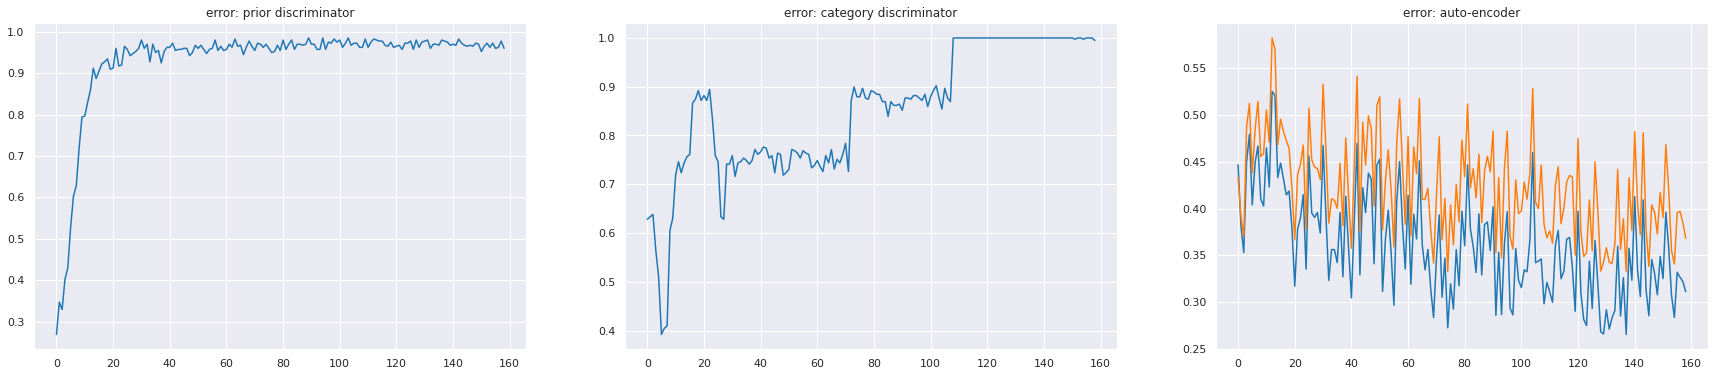

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30, 6)

axes[0].plot([loss[1] for loss in losses_disc])
axes[1].plot([loss[1] for loss in losses_disc_cat])
axes[2].plot([loss[1] for loss in losses_ae])
axes[2].plot([loss[1] for loss in losses_val])

axes[0].set_title('error: prior discriminator')
axes[1].set_title('error: category discriminator')
axes[2].set_title('error: auto-encoder')

fig.show()

## Example of GAN output

Here we show what the model does inside with on from left to right:

1. the input
2. the encoded time-serie
3. the cluster labeling
4. the decoded output
5. the error between decoded and input

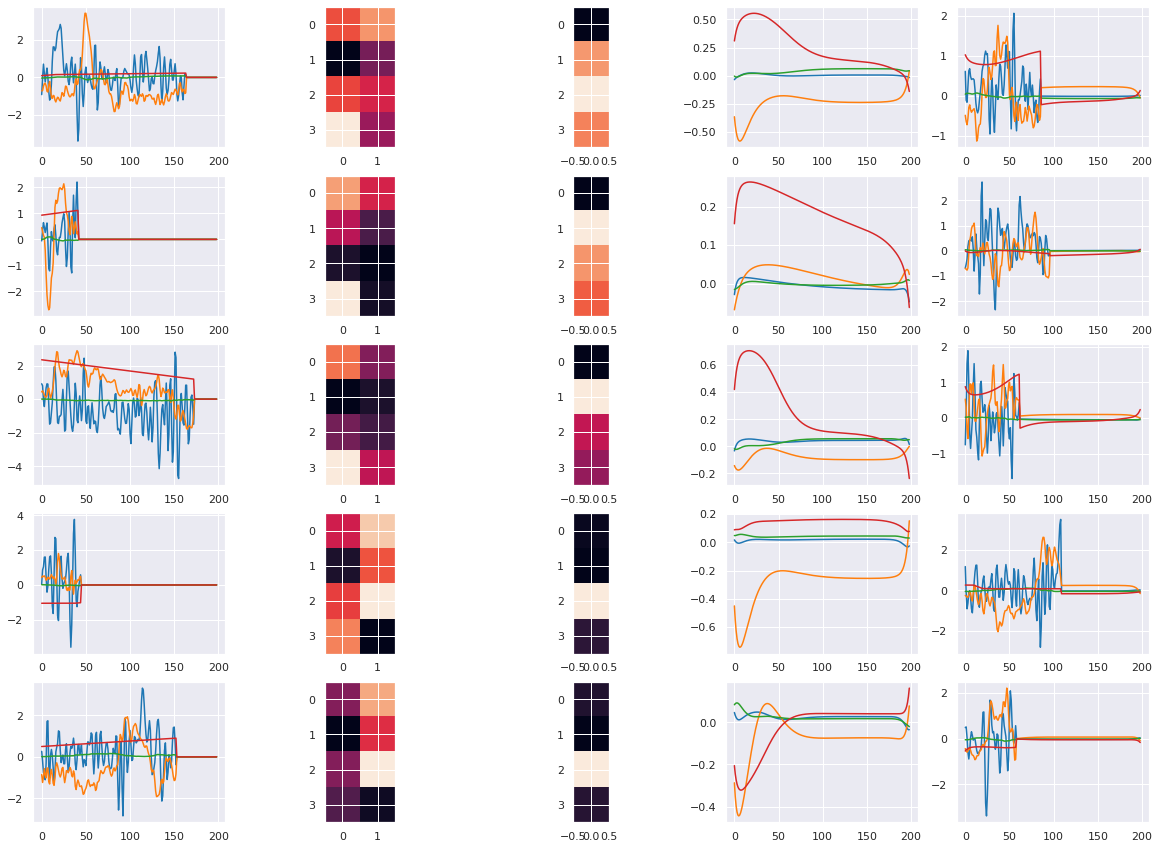

In [20]:
test_batch = 5

fig, axes = plt.subplots(nrows=test_batch, ncols=5)
fig.set_size_inches(20, 3 * test_batch)

random_batch = np.random.randint(len(test_x), size=test_batch)
(dec, rep, cat, error) = encoder.predict(test_x[random_batch])

for i in range(test_batch):
    axes[i,0].plot(test_x[i])
    axes[i,1].imshow(rep[i].reshape(input_dim,int(latent_dim/input_dim)))
    axes[i,2].imshow(cat[i].reshape(cat_dim, 1))
    axes[i,3].plot(dec[i])
    axes[i,4].plot(error[i])

fig.show()

# Data post-processing

In [24]:
dfout.to_parquet(Path(folderpath, 'dl_gan', 'output.parquet'))

In [206]:
dfout = pd.concat([
    pd.DataFrame(rep, index=dataset.index).add_prefix('encode_'),
    pd.DataFrame(cat, index=dataset.index).add_prefix('cluster_'),
    pd.DataFrame(categories, index=dataset.index, columns=['cluster']),
], axis=1)

display(dfout.head())

,encode_0,encode_1,encode_2,encode_3,encode_4,encode_5,encode_6,encode_7,cluster_0,cluster_1,cluster_2,cluster_3,cluster
corner_select,,,,,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY28x41,0.044137,0.717148,-0.910041,0.136094,-0.142731,0.942378,0.169816,-1.096735,0.122516,0.105317,0.590506,0.181661,2
12km-D5-AGGRESSIVE-SECONDARY56x01,0.530999,0.383051,-0.529608,0.101580,0.286603,0.199557,0.831332,-0.090387,0.141238,0.246366,0.345025,0.267371,2
12km-D5-AGGRESSIVE-SECONDARY6x91,0.734869,-0.370584,-0.845876,-1.042340,-0.242826,-0.055261,1.520784,0.727375,0.132726,0.409459,0.218788,0.239026,1
13km-D1-DROWSY-SECONDARY2x14,-0.644983,0.491528,-0.238239,-0.152461,-0.754647,-0.244120,-0.659645,-0.457272,0.339838,0.314180,0.155167,0.190815,0
13km-D1-DROWSY-SECONDARY61x24,0.232243,0.884134,-0.785839,0.323067,0.370795,0.924723,0.601011,-0.909765,0.106987,0.094566,0.618050,0.180397,2
